 # Count And Identify Trees

In [1]:
import rasterio
from rasterio.transform import from_origin
from rasterio.windows import Window
from rasterio import logging as rasterio_logging
from deepforest import main
from deepforest import utilities
import ffmpeg
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, HTML
from PIL import Image as PILImage
import folium
from dotenv import load_dotenv

rasterio_logger = rasterio_logging.getLogger()
rasterio_logger.setLevel(rasterio_logging.ERROR)
load_dotenv()

True

In [2]:
class SrtParser:
    def __init__(self,path):
        self.path = path
        file_to_read = open(path,'r')
        self.data = file_to_read.read()
        file_to_read.close()
        self.subtitles = pd.DataFrame(columns=['index','start','end','text','longitude','latitude','distance','height','horizontal_speed','vertical_speed','longitude_key','latitude_key'])

    def parseTime(self,time_str):
        # Extract hours, minutes, and seconds from the time string
        hours, minutes, seconds_milliseconds = time_str.split(':')
        seconds, milliseconds = seconds_milliseconds.split(',')
        
        # Convert hours, minutes, and seconds to integers
        hours = int(hours)
        minutes = int(minutes)
        seconds = int(seconds)
        milliseconds = int(milliseconds)
        
        # Return the total number of milliseconds
        return (hours * 3600 + minutes * 60 + seconds) * 1000 + milliseconds


    def parseSubtitle(self,subtitle_str):
        # Split the subtitle string into lines
        lines = subtitle_str.strip().split('\n')
        
        # Extract the index, start, and end times from the first line
        index = int(lines[0])
        start, end = map(self.parseTime, lines[1].split(' --> '))
        
        # Join the remaining lines into a single string
        text = '\n'.join(lines[2:])

        #parameters
        longitude = float(text.split(',')[4].lstrip('GPS ('))
        latitude = float(text.split(',')[5])
        distance = float(text.split(',')[7].lstrip('D ').rstrip('m'))
        height = float(text.split(',')[8].lstrip('H ').rstrip('m'))
        horizontal_speed = float(text.split(',')[9].lstrip('H.S ').rstrip('m/s'))
        vertical_speed = float(text.split(',')[10].lstrip('V.S ').rstrip('m/s'))

        # Create and return a Subtitle object
        new_subtitle = pd.DataFrame.from_dict({
            'index': [index],
            'start': [start],
            'end': [end],
            'text': [text],
            'longitude': [longitude],
            'latitude': [latitude],
            'distance': [distance],
            'height': [height],
            'horizontal_speed': [horizontal_speed],
            'vertical_speed': [vertical_speed]
        })
        self.subtitles = pd.concat([self.subtitles,new_subtitle],ignore_index=True)

    def parseSrt(self,srt_str):
        # Split the srt string into a list of subtitle strings
        subtitles = re.split('\n\n+', srt_str.strip())
        
        # Parse each subtitle string and return a list of Subtitle objects
        for subtitle in subtitles:
            self.parseSubtitle(subtitle)
        return self.subtitles

    def findDirectionOf(self,start):
        lat = self.subtitles.at[start,'latitude']
        lon = self.subtitles.at[start,'longitude']
        for i in range(start+1, len(self.subtitles)):
            lat_at_i = self.subtitles.at[i,'latitude']
            lon_at_i = self.subtitles.at[i,'longitude']
            if lat_at_i != lat or lon_at_i != lon:
                return np.arctan2(lat_at_i - lat, lon_at_i - lon)
        return 0

    def determineKeyPosition(self):
        for index, row in self.subtitles.iterrows():
            if index == 0 or self.subtitles.at[index-1,'longitude'] != row['longitude'] or self.subtitles.at[index-1,'latitude'] != row['latitude']:
                lon = row['longitude']
                lat = row['latitude']
            else:
                lon = self.subtitles.at[index-1,'longitude_key']
                lat = self.subtitles.at[index-1,'latitude_key']
            horizontal_distance = row['horizontal_speed'] / 100000
            bearing = self.findDirectionOf(index)
            self.subtitles.at[index,'longitude_key'] = lon + np.cos(bearing) * horizontal_distance
            self.subtitles.at[index,'latitude_key'] = lat + np.sin(bearing) * horizontal_distance

    
    def parse(self):
        self.parseSrt(self.data)
        self.determineKeyPosition()
        return self.subtitles

In [3]:
def prepareEnv(envName):
    #If a path or filename is provided the env name is the basename of the given filename.
    envName = os.path.basename(envName).split('.')[0]

    if not os.path.exists('data'):
        os.makedirs('data')
    envPath = 'data/%s'%envName
    if not os.path.exists(envPath):
        os.makedirs(envPath)
    srcImgsPath = '%s/srcImgs'%envPath
    if not os.path.exists(srcImgsPath):
        os.makedirs(srcImgsPath)
    geoImgsPath = '%s/geoImgsPath'%envPath
    if not os.path.exists(geoImgsPath):
        os.makedirs(geoImgsPath)

    config = {
        'envName': envName,
        'envPath': envPath,
        'srcImgsPath': srcImgsPath,
        'geoImgsPath': geoImgsPath,
        'metaSrtFile': '%s/subs.srt' % envPath,
        'srcImgsFile': '%s/%s'%(srcImgsPath,"src_%05d.png")
    }

    return config


In [4]:

def extractMetaFromVideo(videoFileName): 
    config = prepareEnv(videoFileName)
    ffmpeg.input(videoFileName).output(config['metaSrtFile'], map = "0:s:0").run(overwrite_output=True)

In [5]:
def createSrcImgs(videoFileName):
    config = prepareEnv(videoFileName)
    ffmpeg.input(videoFileName).output(config['srcImgsFile'],vf='crop=ih:ih,scale=400:-1',r=1).run(overwrite_output=True)

In [6]:
def generateGeoCodeImage(videoFileName,second,latidute,longitude):
    config = prepareEnv(videoFileName)
    src = rasterio.open('%s/src_%05d.png'%(config['srcImgsPath'],second))
    width, height = src.width, src.height
    size = min(width, height)
    pixel_size = 0.0000004
    #x_origin = latidute + ((size-1) * pixel_size)
    #y_origin = longitude - ((size-1) * pixel_size)
    transform = from_origin(longitude,latidute , pixel_size, pixel_size)  # Set the latitude and longitude coordinates as the origin

    # Set the metadata for the GeoTIFF
    meta = {
        'driver': 'GTiff',
        'dtype': 'uint8',
        'nodata': 0,
        'width': size,
        'height': size,
        'count': 3,
        'crs': rasterio.crs.CRS.from_epsg(4326),  # Set the CRS to EPSG: 4326 (WGS 84)
        'transform': transform  # Set the latitude and longitude coordinates as the origin
    }

    # Create the GeoTIFF file
    with rasterio.open('%s/geo_%05d.tiff'%(config['geoImgsPath'],second), 'w', **meta) as dst:
        #x_offset = (width - size) // 2
        #y_offset = (height - size) // 2
        #window = Window(x_offset, y_offset, size, size)

        # Copy the data from the source image to the GeoTIFF
        dst.write(src.read()) # window=window

    src.close()

In [7]:
class AI:
    def __init__(self):
        self.main = main.deepforest()
        self.main.use_release(check_release=False)
        self.predictedTrees = False
        
    def predictAsDf(self,videoFileName,second):
        config = prepareEnv(videoFileName)
        path = '%s/geo_%05d.tiff'%(config['geoImgsPath'],second)
        r = rasterio.open(path)
        transform = r.transform 
        crs = r.crs
        r.close()

        df = self.main.predict_image(path=path)
        gdf = utilities.annotations_to_shapefile(df, transform=transform, crs=crs)
        if self.predictedTrees is False:
            self.predictedTrees = gdf
        else:
            self.predictedTrees = pd.concat([self.predictedTrees,gdf],axis=0)
        return gdf
    
    def predictAsImg(self,videoFileName,second):
        config = prepareEnv(videoFileName)
        path = '%s/geo_%05d.tiff'%(config['geoImgsPath'],second)
        return self.main.predict_image(path=path,return_plot=True,thickness=5)
    
    def toCsv(self,videoFileName):
        config = prepareEnv(videoFileName)
        if self.predictedTrees is not False:
            self.predictedTrees.to_csv('%s/predictions.csv'%config['envPath'],index=False)

In [8]:
videoFileName = "/Users/hakanonal/Downloads/temp_video_for_share.mp4"
config = prepareEnv(videoFileName)

In [9]:
extractMetaFromVideo(videoFileName)

ffmpeg version N-109428-g10a56363a7-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-config-flags=--static

In [10]:
srtParser = SrtParser(config['metaSrtFile'])
metaData = srtParser.parse()
metaData

,index,start,end,text,longitude,latitude,distance,height,horizontal_speed,vertical_speed,longitude_key,latitude_key
0,1,0,1000,"F/2.8, SS 1092.75, ISO 110, EV 0, GPS (28.0279...",28.0279,38.5969,23.50,2.9,0.00,0.0,28.0279,38.5969
1,2,1000,2000,"F/2.8, SS 1092.75, ISO 110, EV 0, GPS (28.0279...",28.0279,38.5969,23.45,2.9,0.20,0.0,28.027902,38.5969
2,3,2000,3000,"F/2.8, SS 1092.75, ISO 110, EV 0, GPS (28.0279...",28.0279,38.5969,23.79,2.9,0.71,0.0,28.027909,38.5969
3,4,3000,4000,"F/2.8, SS 1092.75, ISO 110, EV 0, GPS (28.0279...",28.0279,38.5969,24.69,2.9,1.41,0.0,28.027923,38.5969
4,5,4000,5000,"F/2.8, SS 1122.74, ISO 110, EV 0, GPS (28.0279...",28.0279,38.5969,26.19,2.8,2.02,0.0,28.027943,38.5969
...,...,...,...,...,...,...,...,...,...,...,...,...
306,307,306000,307000,"F/2.8, SS 242.51, ISO 100, EV 0, GPS (28.0274,...",28.0274,38.5964,57.10,32.4,1.63,0.0,28.027416,38.5964
307,308,307000,308000,"F/2.8, SS 242.51, ISO 100, EV 0, GPS (28.0274,...",28.0274,38.5964,55.54,32.4,1.63,0.0,28.027433,38.5964
308,309,308000,309000,"F/2.8, SS 242.51, ISO 100, EV 0, GPS (28.0274,...",28.0274,38.5964,53.98,32.4,1.61,0.0,28.027449,38.5964
309,310,309000,310000,"F/2.8, SS 245.15, ISO 100, EV 0, GPS (28.0274,...",28.0274,38.5964,52.44,32.5,1.63,0.0,28.027465,38.5964


In [11]:
# No need to execute this everytime. Un-comment and execute it when analyzing a fresh video create images from video for each second.
#createSrcImgs(videoFileName)

Reading config file: /Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/deepforest/data/deepforest_config.yml


/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/deepforest/utilities.py:431: UserWarning: This method is deprecated and will be removed in version DeepForest 2.0.0, please use boxes_to_shapefile which unifies project_boxes and annotations_to_shapefile functionalities
  warnings.warn("This method is deprecated and will be removed in version DeepForest 2.0.0, please use boxes_to_shapefile which unifies project_boxes and annotations_to_shapefile functionalities")
/Users/hakanonal/opt/anaconda3/envs/treecounter/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = Dat

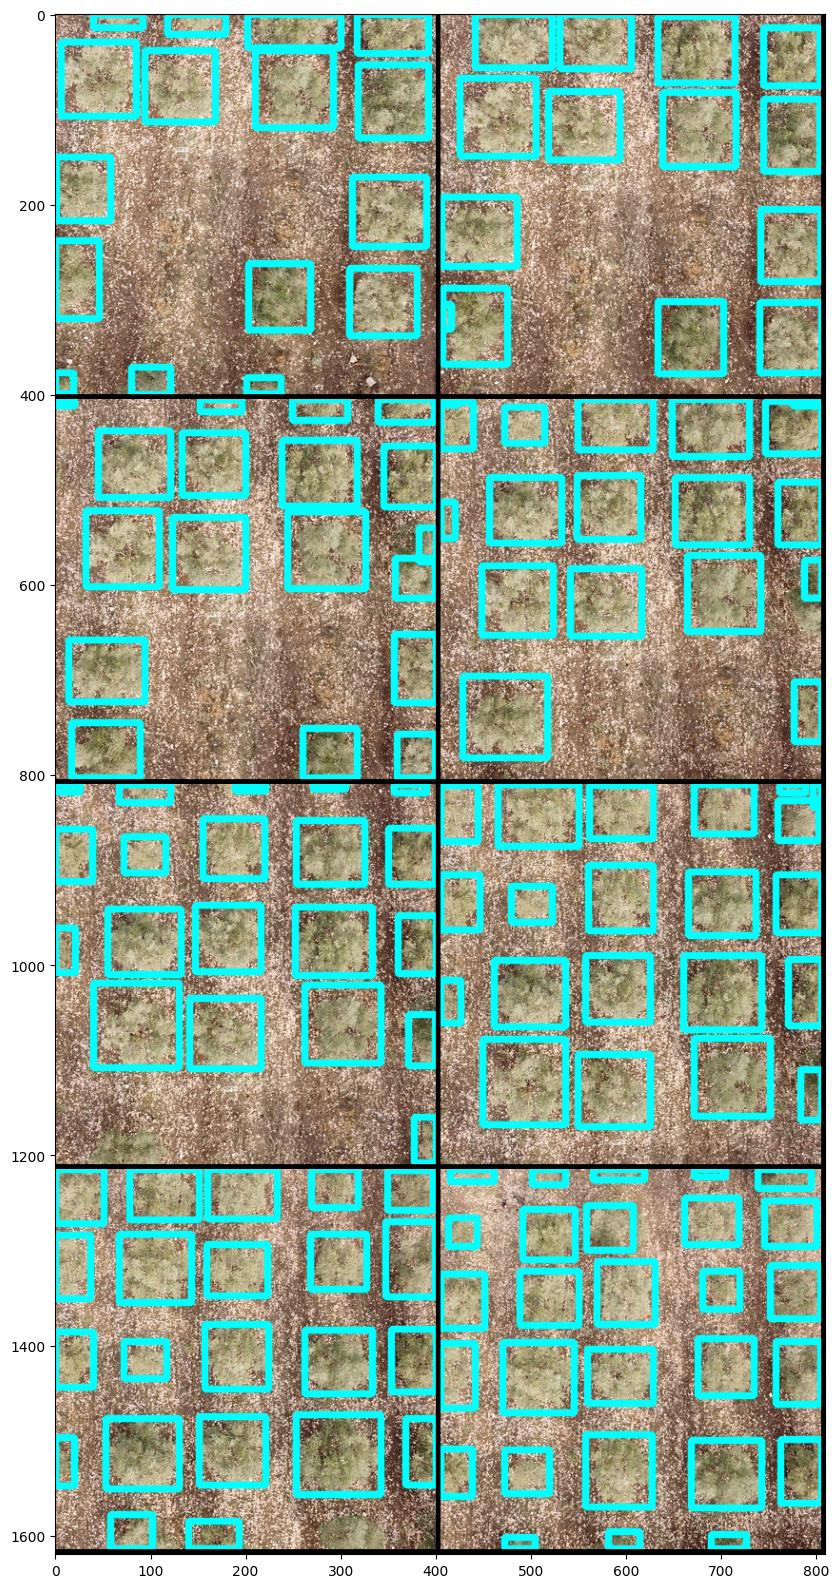

In [14]:
def predict_concequtive_images_and_tile_in_a_plt():
    size=400
    margin=5
    starting_second = 230
    total_number_ofseconds = 8
    tile = 2
    results = []
    row=[]
    df = False

    for k in range(starting_second,starting_second+total_number_ofseconds):
        generateGeoCodeImage(videoFileName,k,metaData.latitude_key[k],metaData.longitude_key[k])
        img = ai.predictAsImg(videoFileName,k)
        gdf = ai.predictAsDf(videoFileName,k)
        i = ((k-starting_second) // tile)
        j = (k-starting_second) % tile
        row.append(img[:,:,::-1])
        row.append(np.zeros((size,margin,3),dtype=int))
        if j == (tile - 1):
            rows = np.concatenate(row, axis=1 )
            results.append(rows)
            results.append(np.zeros((margin,(size+margin)*tile,3),dtype=int))
            row=[]
    results = np.concatenate(results, axis=0 )
    ai.toCsv(videoFileName)

    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()

ai = AI()
predict_concequtive_images_and_tile_in_a_plt()


In [15]:
from folium.features import FeatureGroup
from folium.map import LayerControl

mapbox_username = 'mapbox'
mapbox_style_id = 'satellite-v9'
mapbox_accesstoken = os.getenv("MAPBOX_ACCESSTOKEN")
m = folium.Map(
    tiles='https://api.mapbox.com/styles/v1/%s/%s/tiles/256/{z}/{x}/{y}@2x?access_token=%s'%(mapbox_username,mapbox_style_id,mapbox_accesstoken),
    attr='Mapbox attribution',
    name='Mapbox Satellite',
    zoom_start=1,
    access_token=mapbox_accesstoken)


predictedPaths = ai.predictedTrees.groupby('image_path')
for group_name,group_df in predictedPaths:
    fg = FeatureGroup(name=group_name)
    for index, row in group_df.iterrows():
        fg.add_child(folium.Polygon([(i[1],i[0]) for i in list(row['geometry'].exterior.coords)][:-1], color="green", fill=True))
    m.add_child(fg)
    m.fit_bounds(fg.get_bounds())

LayerControl().add_to(m)
m
